# Make the Dataset

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sak2311","key":"3ed8d88fe7b8b627ba2c17da26212c2a"}'}

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os
current_dir = os.getcwd()
print(current_dir)

/content


In [ ]:
! kaggle datasets download dasmehdixtr/ddti-thyroid-ultrasound-images
print(os.getcwd())

 29% 5.00M/17.2M [00:00<00:00, 45.5MB/s]
100% 17.2M/17.2M [00:00<00:00, 114MB/s] 
/content


In [ ]:
! unzip ddti-thyroid-ultrasound-images.zip

Archive:  ddti-thyroid-ultrasound-images.zip
  inflating: 1.xml                   
  inflating: 10.xml                  
  inflating: 100.xml                 
  inflating: 100_1.jpg               
  inflating: 101.xml                 
  inflating: 101_1.jpg               
  inflating: 102.xml                 
  inflating: 102_1.jpg               
  inflating: 103.xml                 
  inflating: 103_1.jpg               
  inflating: 104.xml                 
  inflating: 104_1.jpg               
  inflating: 105.xml                 
  inflating: 105_1.jpg               
  inflating: 106.xml                 
  inflating: 106_1.jpg               
  inflating: 106_2.jpg               
  inflating: 106_3.jpg               
  inflating: 106_4.jpg               
  inflating: 107.xml                 
  inflating: 107_1.jpg               
  inflating: 108.xml                 
  inflating: 108_1.jpg               
  inflating: 109.xml                 
  inflating: 109_1.jpg               
  inf

In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET  # For parsing the XML files
from xml.dom import minidom  # For prettifying the XML files
import os
import shutil  # For copying files from /kaggle/input to /kaggle/working

paths = []
for dirname, _, filenames in os.walk("/content/"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

# Split all paths by extension
xmls = []
jpgs = []
for path in paths:
    if path.split('.')[-1] == "xml":
        xmls.append(path)
    if path.split('.')[-1] == "jpg":
        jpgs.append(path)

print(f"{len(xmls)} XMLs + {len(jpgs)} JPGs = {len(paths)} paths")

os.mkdir("/content/images")  # Will contain only the images that were not excluded during preprocessing
os.mkdir("/content/masks")  # Will contain the masks for each image

390 XMLs + 480 JPGs = 892 paths


In [ ]:
# Print an XML file
tree = ET.parse(xmls[4])
rough_string = ET.tostring(tree.getroot(), 'utf8')
reparsed = minidom.parseString(rough_string)
print(reparsed.toprettyxml(indent="  ").replace("&quot;", '"'))

<?xml version="1.0" ?>
<case>
  <number>32</number>
  <age>42</age>
  <sex>F</sex>
  <composition>solid</composition>
  <echogenicity>hyperechogenicity</echogenicity>
  <margins>well defined</margins>
  <calcifications>non</calcifications>
  <tirads>4a</tirads>
  <reportbacaf/>
  <reporteco/>
  <mark>
    <image>1</image>
    <svg>[{"points": [{"x": 264, "y": 112}, {"x": 246, "y": 111}, {"x": 226, "y": 113}, {"x": 216, "y": 122}, {"x": 214, "y": 130}, {"x": 214, "y": 139}, {"x": 217, "y": 148}, {"x": 219, "y": 153}, {"x": 224, "y": 160}, {"x": 235, "y": 174}, {"x": 243, "y": 177}, {"x": 285, "y": 180}, {"x": 287, "y": 178}, {"x": 292, "y": 175}, {"x": 297, "y": 169}, {"x": 301, "y": 163}, {"x": 305, "y": 153}, {"x": 307, "y": 146}, {"x": 306, "y": 136}, {"x": 301, "y": 130}, {"x": 296, "y": 129}, {"x": 289, "y": 125}, {"x": 283, "y": 121}, {"x": 277, "y": 117}, {"x": 269, "y": 116}], "annotation": {}, "regionType": "freehand"}]</svg>
  </mark>
</case>



In [ ]:
# Create a dictionary for the data so that we can make it a pd.DataFrame
data = {
    "Number": [],
    "Age": [],
    "Sex": [],
    "Composition": [],
    "Echogenicity": [],
    "Margins": [],
    "Calcifications": [],
    "Tirads": [],
    "Reportbacaf": [],
    "Reporteco": [],
}
svg_strings = {}  # To hold the SVG of each image of every case

# Parse every xml file and add the data to the dictionary
for xml in xmls:
    tree = ET.parse(xml)
    root = tree.getroot()
    case_number = int(root.find("number").text)
    data["Number"].append(case_number)
    if root.find("age").text:
        data["Age"].append(int(root.find("age").text))
    else:
        data["Age"].append(root.find("age").text)
    data["Sex"].append(root.find("sex").text)
    data["Composition"].append(root.find("composition").text)
    data["Echogenicity"].append(root.find("echogenicity").text)
    data["Margins"].append(root.find("margins").text)
    data["Calcifications"].append(root.find("calcifications").text)
    data["Tirads"].append(root.find("tirads").text)
    data["Reportbacaf"].append(root.find("reportbacaf").text)
    data["Reporteco"].append(root.find("reporteco").text)

    # Get SVGs. Key: <{case number}_{image index}> which is the same as the respective image filename
    for mark in root.findall("mark"):
        image_idx = mark.find("image").text
        svg_strings[f"{case_number}_{image_idx}"] = mark.find("svg").text

df = pd.DataFrame(data)
df.sort_values(by="Number", inplace=True)
df.set_index("Number", inplace=True)
display(df)

,Age,Sex,Composition,Echogenicity,Margins,Calcifications,Tirads,Reportbacaf,Reporteco
Number,,,,,,,,,
1,NaN,None,None,None,None,None,None,None,None
2,49.0,F,solid,hyperechogenicity,well defined,non,2,None,None
3,31.0,F,spongiform,isoechogenicity,well defined,microcalcifications,4a,None,None
4,37.0,F,spongiform,isoechogenicity,well defined,microcalcifications,4a,None,None
5,47.0,F,solid,hypoechogenicity,ill defined,microcalcifications,5,None,None
...,...,...,...,...,...,...,...,...,...
396,NaN,None,None,None,None,None,None,None,None
397,39.0,F,None,None,well defined smooth,non,2,None,THYROIDITIS
398,70.0,F,None,None,spiculated,non,4b,None,None


In [ ]:
df = df.rename_axis('cases').reset_index()

In [ ]:
df_1 = None
df_2=df[df['Tirads'] == '2']
df_3=df[df['Tirads'] == '3']
df_4a=df[df['Tirads'] == '4a']
df_4b=df[df['Tirads'] == '4b']
df_4c = df[df['Tirads'] == '4c']
df_5=df[df['Tirads'] == '5']

In [ ]:
#T1 = df_1['cases'].to_numpy()
T2 = df_2['cases'].to_numpy()
T3 = df_3['cases'].to_numpy()
T4a = df_4a['cases'].to_numpy()
T4b = df_4b['cases'].to_numpy()
T4c = df_4c['cases'].to_numpy()
T5 = df_5['cases'].to_numpy()
T = df['cases'].to_numpy()
#print(T3)
print(len(T2))
print(len(T3))
print(len(T4a))
print(len(T4b))
print(len(T4c))
print(len(T5))

38
14
85
75
56
30


In [ ]:
T1a = [i for i in T if i not in T2]
T1b = [i for i in T1a if i not in T3]
T1c = [i for i in T1b if i not in T4a]
T1d = [i for i in T1c if i not in T4b]
T1e = [i for i in T1d if i not in T5]
T1f = [i for i in T1e if i not in T4c]
T1 = T1f
print(T1)
print(len(T1))

[1, 58, 59, 60, 62, 63, 64, 69, 71, 72, 75, 77, 84, 87, 92, 96, 97, 99, 104, 106, 114, 116, 117, 120, 124, 132, 133, 136, 138, 139, 140, 145, 146, 147, 149, 150, 152, 157, 158, 159, 161, 163, 165, 169, 173, 175, 181, 182, 183, 188, 189, 196, 199, 200, 208, 210, 213, 222, 223, 226, 229, 230, 232, 234, 235, 237, 238, 239, 240, 241, 245, 249, 250, 253, 254, 256, 260, 262, 266, 273, 274, 276, 280, 287, 312, 323, 326, 332, 349, 388, 389, 396]
92


In [ ]:
def add1(i):
  return str(i)+"_1"+".jpg"

In [ ]:
casesT1 = [add1(i) for i in T1]
casesT2 = [add1(i) for i in T2]
casesT3 = [add1(i) for i in T3]
casesT4a = [add1(i) for i in T4a]
casesT4b = [add1(i) for i in T4b]
casesT4c = [add1(i) for i in T4c]
casesT5 = [add1(i) for i in T5]

In [ ]:
os.mkdir('/content/working')

In [ ]:
os.mkdir('/content/notneeded')

In [ ]:
No2 = []
for file in os.listdir("/content"):
  if file.endswith("_2.jpg"):
    temp = str(file)
    if len(temp)==9:
      s2 = slice(3)
      temp2=temp[s2]
    elif len(temp)==8:
      s2 = slice(2)
      temp2=temp[s2]
    else:
      s2 = slice(1)
      temp2=temp[s2]
    temp3=temp2+'_1.jpg'
    No2.append(temp3)
    os.rename(os.path.join("/content/", file),  os.path.join('/content/working', temp3))

In [ ]:
print(No2)

['75_1.jpg', '69_1.jpg', '233_1.jpg', '353_1.jpg', '156_1.jpg', '334_1.jpg', '210_1.jpg', '213_1.jpg', '129_1.jpg', '81_1.jpg', '296_1.jpg', '336_1.jpg', '88_1.jpg', '294_1.jpg', '65_1.jpg', '358_1.jpg', '99_1.jpg', '371_1.jpg', '1_1.jpg', '315_1.jpg', '173_1.jpg', '183_1.jpg', '234_1.jpg', '62_1.jpg', '97_1.jpg', '114_1.jpg', '367_1.jpg', '189_1.jpg', '347_1.jpg', '138_1.jpg', '266_1.jpg', '96_1.jpg', '80_1.jpg', '106_1.jpg', '330_1.jpg', '92_1.jpg', '163_1.jpg', '90_1.jpg', '122_1.jpg', '350_1.jpg', '198_1.jpg', '337_1.jpg', '85_1.jpg', '313_1.jpg', '58_1.jpg', '158_1.jpg', '130_1.jpg', '360_1.jpg', '227_1.jpg', '381_1.jpg', '64_1.jpg', '359_1.jpg', '395_1.jpg', '366_1.jpg', '146_1.jpg', '142_1.jpg', '225_1.jpg', '175_1.jpg', '387_1.jpg', '391_1.jpg', '230_1.jpg', '373_1.jpg', '317_1.jpg', '157_1.jpg', '319_1.jpg', '351_1.jpg', '209_1.jpg', '335_1.jpg', '338_1.jpg', '132_1.jpg', '139_1.jpg', '93_1.jpg', '318_1.jpg', '177_1.jpg']


In [ ]:
NotNeeded = []
for i in No2:
  for file in os.listdir('/content'):
    if file == i:
      os.rename(os.path.join("/content/", file),  os.path.join('/content/notneeded', file))
      temp45 = str(file)
      NotNeeded.append(temp45)

In [ ]:
print(NotNeeded)

['75_1.jpg', '69_1.jpg', '233_1.jpg', '353_1.jpg', '156_1.jpg', '334_1.jpg', '210_1.jpg', '213_1.jpg', '129_1.jpg', '81_1.jpg', '296_1.jpg', '88_1.jpg', '294_1.jpg', '65_1.jpg', '358_1.jpg', '99_1.jpg', '371_1.jpg', '1_1.jpg', '315_1.jpg', '173_1.jpg', '183_1.jpg', '234_1.jpg', '62_1.jpg', '97_1.jpg', '367_1.jpg', '189_1.jpg', '347_1.jpg', '138_1.jpg', '266_1.jpg', '96_1.jpg', '80_1.jpg', '106_1.jpg', '330_1.jpg', '92_1.jpg', '163_1.jpg', '90_1.jpg', '122_1.jpg', '350_1.jpg', '198_1.jpg', '337_1.jpg', '85_1.jpg', '313_1.jpg', '58_1.jpg', '158_1.jpg', '130_1.jpg', '360_1.jpg', '227_1.jpg', '381_1.jpg', '64_1.jpg', '359_1.jpg', '395_1.jpg', '366_1.jpg', '146_1.jpg', '142_1.jpg', '225_1.jpg', '175_1.jpg', '387_1.jpg', '391_1.jpg', '230_1.jpg', '373_1.jpg', '317_1.jpg', '157_1.jpg', '319_1.jpg', '351_1.jpg', '209_1.jpg', '335_1.jpg', '338_1.jpg', '132_1.jpg', '139_1.jpg', '93_1.jpg', '318_1.jpg', '177_1.jpg']


In [ ]:
for file in os.listdir("/content"):
    if file.endswith("_1.jpg"):
      os.rename(os.path.join("/content/", file),  os.path.join('/content/working', file))

In [ ]:
import shutil
#shutil.rmtree('/content/notneeded')

In [ ]:
DIR = '/content/working'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

390


In [ ]:
os.mkdir('/content/TIRADS1')
os.mkdir('/content/TIRADS2')
os.mkdir('/content/TIRADS3')
os.mkdir('/content/TIRADS4a')
os.mkdir('/content/TIRADS4b')
os.mkdir('/content/TIRADS4c')
os.mkdir('/content/TIRADS5')

In [ ]:
import shutil

src = "/content/working/"
dest1 = "/content/TIRADS1/"
dest2 = "/content/TIRADS2/"
dest3 = "/content/TIRADS3/"
dest4a = "/content/TIRADS4a/"
dest4b = "/content/TIRADS4b/"
dest4c = "/content/TIRADS4c/"
dest5 = "/content/TIRADS5/"

def thefiles(src, dest, case):
  for file in case:
      # construct full file path
      source = src + file
      destination = dest + file
      # move file
      shutil.move(source, destination)
      print('Moved:', file)

In [ ]:
thefiles(src, dest1, casesT1)
thefiles(src, dest2, casesT2)
thefiles(src, dest3, casesT3)
thefiles(src, dest4a, casesT4a)
thefiles(src, dest4b, casesT4b)
thefiles(src, dest4c, casesT4c)
thefiles(src, dest5, casesT5)

Moved: 1_1.jpg
Moved: 58_1.jpg
Moved: 59_1.jpg
Moved: 60_1.jpg
Moved: 62_1.jpg
Moved: 63_1.jpg
Moved: 64_1.jpg
Moved: 69_1.jpg
Moved: 71_1.jpg
Moved: 72_1.jpg
Moved: 75_1.jpg
Moved: 77_1.jpg
Moved: 84_1.jpg
Moved: 87_1.jpg
Moved: 92_1.jpg
Moved: 96_1.jpg
Moved: 97_1.jpg
Moved: 99_1.jpg
Moved: 104_1.jpg
Moved: 106_1.jpg
Moved: 114_1.jpg
Moved: 116_1.jpg
Moved: 117_1.jpg
Moved: 120_1.jpg
Moved: 124_1.jpg
Moved: 132_1.jpg
Moved: 133_1.jpg
Moved: 136_1.jpg
Moved: 138_1.jpg
Moved: 139_1.jpg
Moved: 140_1.jpg
Moved: 145_1.jpg
Moved: 146_1.jpg
Moved: 147_1.jpg
Moved: 149_1.jpg
Moved: 150_1.jpg
Moved: 152_1.jpg
Moved: 157_1.jpg
Moved: 158_1.jpg
Moved: 159_1.jpg
Moved: 161_1.jpg
Moved: 163_1.jpg
Moved: 165_1.jpg
Moved: 169_1.jpg
Moved: 173_1.jpg
Moved: 175_1.jpg
Moved: 181_1.jpg
Moved: 182_1.jpg
Moved: 183_1.jpg
Moved: 188_1.jpg
Moved: 189_1.jpg
Moved: 196_1.jpg
Moved: 199_1.jpg
Moved: 200_1.jpg
Moved: 208_1.jpg
Moved: 210_1.jpg
Moved: 213_1.jpg
Moved: 222_1.jpg
Moved: 223_1.jpg
Moved: 226_1.jpg

In [ ]:
a = '/content/TIRADS1'
A = len([name for name in os.listdir(a) if os.path.isfile(os.path.join(a, name))])
b = '/content/TIRADS2'
B = len([name for name in os.listdir(b) if os.path.isfile(os.path.join(b, name))])
c = '/content/TIRADS3'
C = len([name for name in os.listdir(c) if os.path.isfile(os.path.join(c, name))])
d = '/content/TIRADS4a'
D = len([name for name in os.listdir(d) if os.path.isfile(os.path.join(d, name))])
e = '/content/TIRADS4b'
E = len([name for name in os.listdir(e) if os.path.isfile(os.path.join(e, name))])
g = '/content/TIRADS4c'
G = len([name for name in os.listdir(g) if os.path.isfile(os.path.join(g, name))])
f = '/content/TIRADS5'
F = len([name for name in os.listdir(f) if os.path.isfile(os.path.join(f, name))])

print(A)
print(B)
print(C)
print(D)
print(E)
print(F)
print(G)
print('Total Images:', A+B+C+E+D+F+G)

92
38
14
85
75
30
56
Total Images: 390


# Augment it

In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2

In [ ]:
src = "/content/working/"
dest1 = "/content/TIRADS1/"
dest2 = "/content/TIRADS2/"
dest3 = "/content/TIRADS3/"
dest4a = "/content/TIRADS4a/"
dest4b = "/content/TIRADS4b/"
dest4c = "/content/TIRADS4c/"
dest5 = "/content/TIRADS5/"

In [ ]:
os.mkdir('/content/Augmented')
os.mkdir('/content/Augmented/TIRADS1')
os.mkdir('/content/Augmented/TIRADS2')
os.mkdir('/content/Augmented/TIRADS3')
os.mkdir('/content/Augmented/TIRADS4a')
os.mkdir('/content/Augmented/TIRADS4b')
os.mkdir('/content/Augmented/TIRADS4c')
os.mkdir('/content/Augmented/TIRADS5')

In [ ]:
dest1A = "/content/Augmented/TIRADS1/"
dest2A = "/content/Augmented/TIRADS2/"
dest3A = "/content/Augmented/TIRADS3/"
dest4aA = "/content/Augmented/TIRADS4a/"
dest4bA = "/content/Augmented/TIRADS4b/"
dest4cA = "/content/Augmented/TIRADS4c/"
dest5A = "/content/Augmented/TIRADS5/"

In [ ]:
def augmentit(dest, destA):
  for file in os.listdir(dest):
    l = file.split('.')
    if len(l) == 1:
      continue
    temp234 = str(file)
    img = cv2.imread(dest+file)
    reshaped_img = cv2.resize(img, (224, 224))
    im1 = np.array(tf.image.random_brightness(reshaped_img, 0.2))
    im2 = np.array(tf.image.random_flip_left_right(reshaped_img))
    cv2.imwrite(destA + file, img)
    cv2.imwrite(destA + 'bright_' + temp234, im1)
    cv2.imwrite(destA + 'flipped_' + temp234, im2)
    cv2.imwrite(destA + 'flipped_2_' + temp234, im2)
    cv2.imwrite(destA + 'bright_2_' + temp234, im1)
    cv2.imwrite(destA + file + '_2', img)
    cv2.imwrite(destA + file + '_3', img)

In [ ]:
augmentit(dest1, dest1A)
augmentit(dest2, dest2A)
augmentit(dest3, dest3A)
augmentit(dest4a, dest4aA)
augmentit(dest4b, dest4bA)
augmentit(dest4c, dest4cA)
augmentit(dest5, dest5A)

In [ ]:
a = '/content/Augmented/TIRADS1'
A = len([name for name in os.listdir(a) if os.path.isfile(os.path.join(a, name))])
b = '/content/Augmented/TIRADS2'
B = len([name for name in os.listdir(b) if os.path.isfile(os.path.join(b, name))])
c = '/content/Augmented/TIRADS3'
C = len([name for name in os.listdir(c) if os.path.isfile(os.path.join(c, name))])
d = '/content/Augmented/TIRADS4a'
D = len([name for name in os.listdir(d) if os.path.isfile(os.path.join(d, name))])
e = '/content/Augmented/TIRADS4b'
E = len([name for name in os.listdir(e) if os.path.isfile(os.path.join(e, name))])
f = '/content/Augmented/TIRADS5'
F = len([name for name in os.listdir(f) if os.path.isfile(os.path.join(f, name))])
g = '/content/Augmented/TIRADS4c'
G = len([name for name in os.listdir(g) if os.path.isfile(os.path.join(g, name))])

print(A)
print(B)
print(C)
print(D)
print(E)
print(F)
print('Total Images after augmentation:', A+B+C+E+D+F)

644
266
98
595
525
210
Total Images after augmentation: 2338


# Split it

In [ ]:
src = '/content/Augmented'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam

In [ ]:
IMAGE_SIZE=[224,224]

In [ ]:
# Training
batch_size=16
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    src,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(IMAGE_SIZE),
    batch_size=batch_size
)

Found 1950 files belonging to 7 classes.
Using 1560 files for training.


In [ ]:
# Same for validation
batch_size=16
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    src,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',
    image_size=(IMAGE_SIZE),
    batch_size=batch_size
)

Found 1950 files belonging to 7 classes.
Using 390 files for validation.


In [ ]:
class_names=train_ds.class_names
print(class_names)

['TIRADS1', 'TIRADS2', 'TIRADS3', 'TIRADS4a', 'TIRADS4b', 'TIRADS4c', 'TIRADS5']


In [ ]:
!pip install split-folders
import splitfolders #to split dataset
import pathlib
# Sakshi's Drive
#base_ds = '/content/drive/MyDrive/dataset thyroid/train'
# Jonathan's Drive
base_ds = '/content/Augmented'
base_ds = pathlib.Path(base_ds)
img_height=224
img_width=224
batch_size=2
splitfolders.ratio(base_ds, output='images', seed=1321, ratio=(.8,.1,.1), group_prefix=None)

batch_size = 16

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

test_ds = datagen.flow_from_directory(
    'images/test',
    target_size = (224, 224),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Copying files: 2730 files [00:00, 5884.52 files/s]

Found 214 images belonging to 7 classes.


# ResNet50

In [ ]:
resnet_model=Sequential()
pretrained_model=tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='avg',
    classes=7)
for layer in pretrained_model.layers:
  layer.trainable=False
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dense(7,activation='softmax'))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_3 (ModuleWr  (None, 2048)              0         
 apper)                                                          
                                                                 
 module_wrapper_4 (ModuleWr  (None, 512)               1049088   
 apper)                                                          
                                                                 
 module_wrapper_5 (ModuleWr  (None, 7)                 3591      
 apper)                                                          
                                                                 
Total params: 24640391 (94.00 MB)
Trainable params: 1052679 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
________

In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Fit the model
epochs=40
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            min_delta = 1e-5,
                                            verbose = 1,
                                            mode = 'min',
                                            restore_best_weights = True)
history=resnet_model.fit(

    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks= [callback]

)

Epoch 1/40
98/98 [==============================] - 15s 100ms/step - loss: 1.8682 - accuracy: 0.3244 - val_loss: 1.7573 - val_accuracy: 0.3436
Epoch 2/40
98/98 [==============================] - 7s 68ms/step - loss: 1.3616 - accuracy: 0.4814 - val_loss: 1.4810 - val_accuracy: 0.4564
Epoch 3/40
98/98 [==============================] - 7s 69ms/step - loss: 1.1016 - accuracy: 0.5891 - val_loss: 1.1505 - val_accuracy: 0.5949
Epoch 4/40
98/98 [==============================] - 8s 81ms/step - loss: 0.8693 - accuracy: 0.6949 - val_loss: 0.9775 - val_accuracy: 0.6769
Epoch 5/40
98/98 [==============================] - 7s 68ms/step - loss: 0.6872 - accuracy: 0.7821 - val_loss: 0.7581 - val_accuracy: 0.7692
Epoch 6/40
98/98 [==============================] - 7s 68ms/step - loss: 0.5695 - accuracy: 0.8179 - val_loss: 0.8003 - val_accuracy: 0.7462
Epoch 7/40
98/98 [==============================] - 7s 70ms/step - loss: 0.3848 - accuracy: 0.8897 - val_loss: 0.5570 - val_accuracy: 0.8308
Epoch 8/40


In [ ]:
resnet_model.save_weights('resnet.h5')

In [ ]:
score=resnet_model.evaluate(test_ds)
print("Loss:",score[0],"Accuracy:",score[1])

14/14 [==============================] - 2s 59ms/step - loss: 0.0736 - accuracy: 0.9766
Loss: 0.07360368967056274 Accuracy: 0.9766355156898499


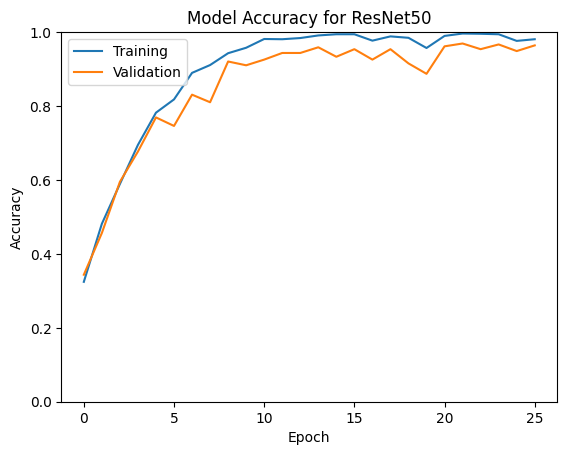

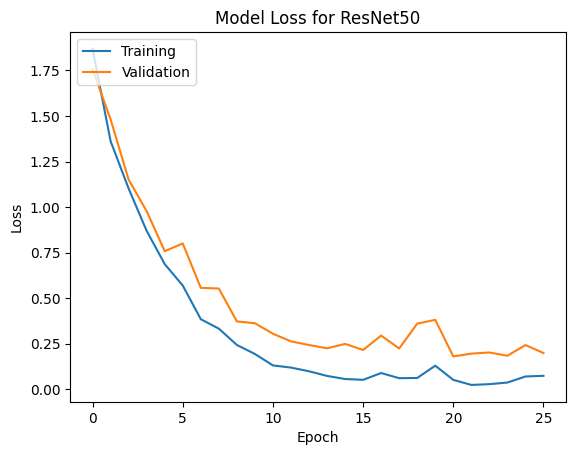

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy for ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.ylim([0,1])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for ResNet50')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# ConvNeXt Tiny


In [ ]:
convnext_model = Sequential()

pretrained_model_3=tf.keras.applications.ConvNeXtTiny(
    model_name="convnext_tiny",
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=7,
    classifier_activation="softmax",
)

for layer in pretrained_model_3.layers:
  layer.trainable=False

convnext_model.add(pretrained_model_3)
convnext_model.add(Flatten())
convnext_model.add(Dense(512, activation= tf.keras.activations.gelu,
                       kernel_regularizer=tf.keras.regularizers.L1(0.03),
                       activity_regularizer=tf.keras.regularizers.L2(0.03))
)
convnext_model.add(tf.keras.layers.Dropout(0.5))
convnext_model.add(Dense(7, activation='softmax'))

111650432/111650432 [==============================] - 1s 0us/step


In [ ]:
convnext_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 768)               27820128  
                                                                 
 module_wrapper (ModuleWrap  (None, 768)               0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 512)               393728    
 apper)                                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 module_wrapper_2 (ModuleWr  (None, 7)                 3591      
 apper)                                                          
                                                        

In [ ]:
convnext_model.compile(optimizer=tf.keras.optimizers.AdamW(
    learning_rate=0.0001,
    weight_decay=0.004,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name="AdamW",
),loss='kullback_leibler_divergence', metrics=['accuracy'])

In [ ]:
ep=40
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            min_delta = 1e-5,
                                            verbose = 1,
                                            mode = 'min',
                                            restore_best_weights = True)
history3 = convnext_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=ep,
    #steps_per_epoch = int(97),
    callbacks=[callback]
)

Epoch 1/40
98/98 [==============================] - 60s 331ms/step - loss: 2.0612 - accuracy: 0.2314 - val_loss: 1.6883 - val_accuracy: 0.3282
Epoch 2/40
98/98 [==============================] - 16s 161ms/step - loss: 1.7068 - accuracy: 0.3288 - val_loss: 1.5708 - val_accuracy: 0.3923
Epoch 3/40
98/98 [==============================] - 16s 163ms/step - loss: 1.5285 - accuracy: 0.4128 - val_loss: 1.4849 - val_accuracy: 0.4231
Epoch 4/40
98/98 [==============================] - 16s 163ms/step - loss: 1.4104 - accuracy: 0.4673 - val_loss: 1.3886 - val_accuracy: 0.4872
Epoch 5/40
98/98 [==============================] - 17s 168ms/step - loss: 1.3405 - accuracy: 0.5006 - val_loss: 1.3297 - val_accuracy: 0.5282
Epoch 6/40
98/98 [==============================] - 16s 163ms/step - loss: 1.2323 - accuracy: 0.5378 - val_loss: 1.2480 - val_accuracy: 0.5872
Epoch 7/40
98/98 [==============================] - 16s 163ms/step - loss: 1.1472 - accuracy: 0.5962 - val_loss: 1.1698 - val_accuracy: 0.6154

In [ ]:
score=convnext_model.evaluate(test_ds)
print("Loss:",score[0],"Accuracy:",score[1])

14/14 [==============================] - 6s 213ms/step - loss: 0.1910 - accuracy: 0.9720
Loss: 0.19104136526584625 Accuracy: 0.9719626307487488


In [ ]:
convnext_model.save_weights('convnext.h5')

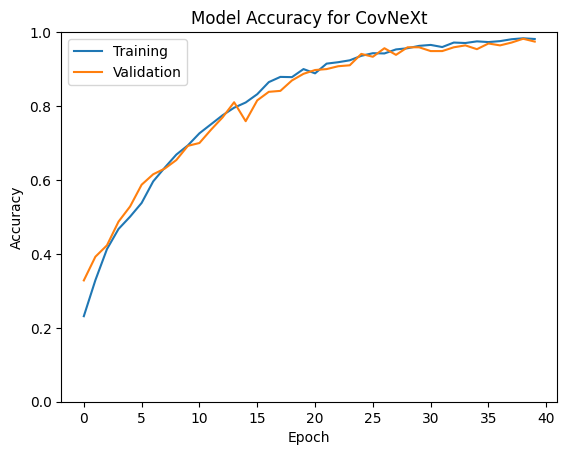

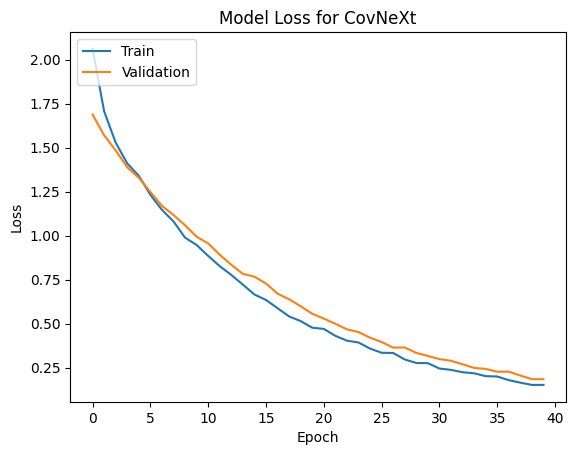

In [ ]:
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy for CovNeXt')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.ylim([0, 1])
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss for CovNeXt')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Final Predictions

In [ ]:
import cv2
# IMAGE_SIZE=(224,224)
image=cv2.imread('/content/malignant.jpg')
image_resized=cv2.resize(image,(IMAGE_SIZE))
image_1=np.expand_dims(image_resized,axis=0)
print(image_1.shape)

(1, 224, 224, 3)


In [ ]:
import numpy as np
pred1=resnet_model.predict(image_1)
print(np.round(pred1, 3))
result=class_names[np.argmax(pred1)]
print("The predicted class is:",result)
print('')
if result == 'TIRADS1':
  print(result,': Normal thyroid Gland')
elif result == 'TIRADS2':
  print(result,': Benign Conditions (0% risk of malignancy)')
elif result == 'TIRADS3':
  print(result,': Probably Benign Nodules (<5% malignancy)')
elif result == 'TIRADS4a':
  print(result,': Suspicious Nodules: Undetermined (5-10% malignancy)')
elif result == 'TIRADS4b':
  print(result,': Suspicious Nodules: Suspicious (10-80% malignancy)')
else:
  print(result,': Probably Malignant Nodules (>80% malignancy)')

In [ ]:
pred2=convnext_model.predict(image_1)
print(np.round(pred2, 3))
result1=class_names[np.argmax(pred2)]
print("The predicted class is:",result1)
print('')
if result1 == 'TI-RADS 1':
  print(result1,': Normal thyroid Gland')
elif result1 == 'TI-RADS 2':
  print(result1,': Benign Conditions (0% risk of malignancy)')
elif result1 == 'TI-RADS 3':
  print(result1,': Probably Benign Nodules (<5% malignancy)')
elif result1 == 'TI-RADS 4a':
  print(result1,': Suspicious Nodules: Undetermined (5-10% malignancy)')
elif result1 == 'TI-RADS 4b':
  print(result1,': Suspicious Nodules: Suspicious (10-80% malignancy)')
else:
  print(result1,': Probably Malignant Nodules (>80% malignancy)')

1/1 [==============================] - 3s 3s/step
[[0.036 0.012 0.002 0.893 0.013 0.04  0.006]]
The predicted class is: TIRADS4a

TIRADS4a : Probably Malignant Nodules (>80% malignancy)
